# Import libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

import re

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load data 

In [2]:
raw_data = pd.read_csv('vehicles.csv')
raw_data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
train_set, test_set = train_test_split(raw_data, test_size = 0.2, random_state = 42)
train_set.shape

(341504, 26)

# Data Preprocessing

## Dropping unnecessary features

In [4]:
# From the raw data, we can already spot some features that will not help us with our analysis
to_drop = ['url', 'region_url', 'VIN','image_url']

In [5]:
df0 = train_set.copy()
df0.head(1)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
366318,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,46995,2017.00,ford,f-150,NaN,8 cylinders,gas,48544.00,clean,automatic,1FTEW1EFXHKC11214,4wd,NaN,truck,black,https://images.craigslist.org/00202_fA8s718RZU...,This 2017 Ford F-150 Lariat 4WD SuperCrew 5.5'...,NaN,tx,29.68,-95.44,2021-04-22T09:03:58-0500


### ID

In [6]:
# Confirming there is one distinct id per row
len(df0) == len(set(df0.id))

True

In [7]:
to_drop.append('id')

### Description

In [8]:
# We do not have any data on purchases, so we cannot know how descriptions could affect buyers' decisions
# Moreover, there are descriptions that seem like spam, however, we cannot be sure
df0.description.head(5)

366318    This 2017 Ford F-150 Lariat 4WD SuperCrew 5.5'...
56271     Coachella Valley Volkswagen        STOCK #:  P...
264620    2016 Ford F-250 Super Duty XL 4x4 4dr Crew Cab...
88787     2021 WOLF ISLANDER 50CC     Offered by: Beyond...
341412    Carvana is the safer way to buy a car During t...
Name: description, dtype: object

In [9]:
to_drop.append('description')

### Posting date

In [10]:
# All offers on the dataset seem to have been posted in a month --between 2021-04-04 and 2021-05-04
# Therefore, no real analysis can be made about prices and a possible seasonal effect
df0.posting_date = pd.to_datetime(df0.posting_date, infer_datetime_format = True)
print(df0[df0.posting_date.isna() == False].posting_date.min())
print(df0[df0.posting_date.isna() == False].posting_date.max())

2021-04-04 03:01:16-04:00
2021-05-04 23:24:09-05:00


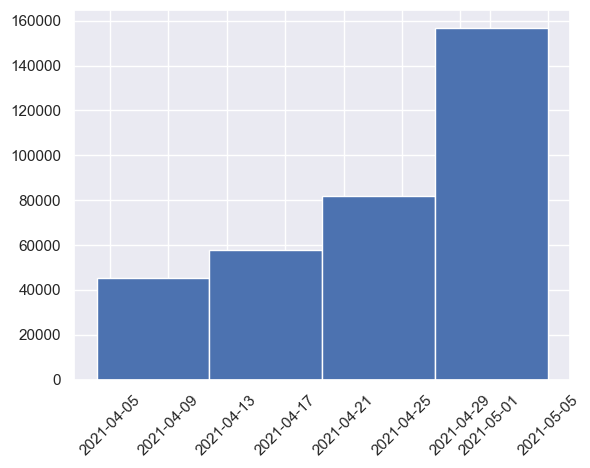

In [11]:
# We can only know that most offers were posted during the second half of the 4 weeks period
df0.posting_date.hist(bins = 4)
plt.xticks(rotation=45)
plt.show()

In [12]:
to_drop.append('posting_date')

### Checking nulls

In [13]:
df0.isnull().sum()[df0.isnull().sum() / len(df0) > 0.5] / len(df0) * 100

size      71.73
county   100.00
dtype: float64

In [14]:
# We can see that 'County' is empty --has 100% of null values-- & 'Size' contains around 70% of null values
to_drop.extend(['county', 'size'])
to_drop

['url',
 'region_url',
 'VIN',
 'image_url',
 'id',
 'description',
 'posting_date',
 'county',
 'size']

### Dropping features

In [15]:
# To keep tracked of features dropped
features_dropped = []
features_dropped.extend(to_drop)

# Dropping identified features
df1 = df0.drop(to_drop, axis = 1)
print(f'{len(to_drop)} features dropped:\n\t({to_drop})')

9 features dropped:
	(['url', 'region_url', 'VIN', 'image_url', 'id', 'description', 'posting_date', 'county', 'size'])


# Exploring remaining features

## Price

In [16]:
df1.price.describe()

count       341504.00
mean         57185.22
std        9361777.68
min              0.00
25%           5900.00
50%          13950.00
75%          26288.50
max     3736928711.00
Name: price, dtype: float64

In [17]:
print('q3-q2: ' + str(26288-13950) + '\nq2-q1: ' + str(13950-5900) )

q3-q2: 12338
q2-q1: 8050


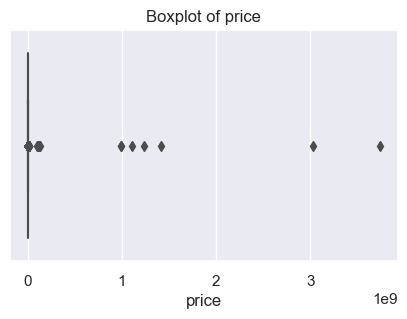

In [18]:
plt.figure(figsize = (5,3))
sns.boxplot(x = df1.price)
plt.title('Boxplot of price')
plt.show()

### Mean, Median & Distribution (skewness)

In [19]:
df1.price.median()

13950.0

In [20]:
round(df1.price.mean() - df1.price.median(), 2)

43235.22

When the **mean** is higher than the **median** this generally implies that the distribution is "Right-Skewed"

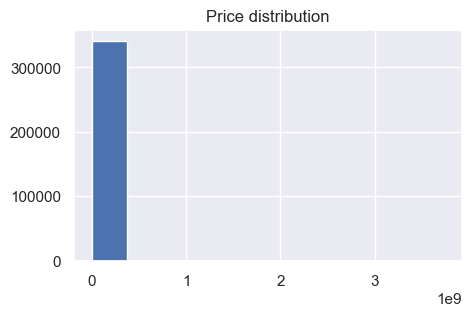

In [21]:
plt.figure(figsize = (5,3))
plt.hist(df1.price)
plt.title('Price distribution')
plt.show()

### Analysis on 'Price'

There are clearly some problems with the 'Price' feature:
* Clear presence of outliers
* **Max price** is 3,736,928,711 
    * The most expensive car ever sold was sold in 2018 for \$48.4 millions at an auction
    * The most expensive car, oficially, has a tag price of \$18.7 millions after taxtes
* **Min price** is 0
    * No car is going to be "sold" at \$0 
    * It is more difficult to know exactly the minimum price at which a car can be sold, but it is rare to see a car selling for less than \\$800 to \$1,000.

### Fixing 'Price'
The objective of this project is to accurately predict the price of a used car. However, as it stands, the dataset contains noise that must be filtered out before modeling. Indeed, even if the 'Price' will be the target, we do not want to predict for a car that should be sold at impossible values.

75% of the data seem to be below \\$26,288.5, so a very conventional range for price, which will still include some outliers that could be encountered with real world data, could be between \\$1,000 and \$70,000

In [22]:
filtered_data = df1[(df1.price > 1000) & (df1.price <= 70000)]
dropped_data = df1[(df1.price < 1000) | (df1.price > 70000)].index
print(f'{len(dropped_data)} rows will be dropped, this is {round(len(dropped_data)/len(df1)*100)}% of the dataset')

39672 rows will be dropped, this is 12% of the dataset


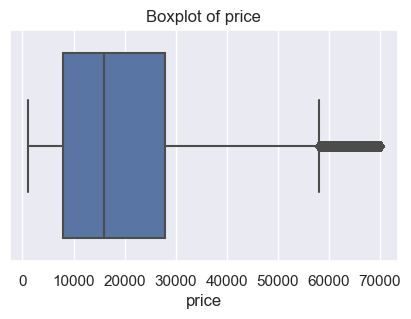

In [23]:
plt.figure(figsize = (5,3))
sns.boxplot(x = filtered_data.price)
plt.title('Boxplot of price')
plt.show()

In [24]:
df2 = df1.drop(dropped_data, axis = 0)
df2.reset_index(inplace = True, drop = True)
df2.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,austin,46995,2017.00,ford,f-150,NaN,8 cylinders,gas,48544.00,clean,automatic,4wd,truck,black,tx,29.68,-95.44
1,albany,36900,2016.00,ford,f-250 super duty,excellent,8 cylinders,gas,73394.00,clean,automatic,4wd,truck,white,ny,42.48,-73.38
2,"washington, DC",1399,2021.00,NaN,WOLF ISLANDER,NaN,NaN,gas,500.00,clean,automatic,NaN,other,orange,dc,38.76,-77.45
3,york,29590,2018.00,buick,enclave essence sport,good,6 cylinders,gas,38459.00,clean,other,fwd,SUV,white,pa,39.96,-76.73
4,lafayette / west lafayette,7950,2008.00,ford,f150 fx/2 sport,excellent,8 cylinders,gas,173267.00,clean,automatic,rwd,pickup,black,in,40.14,-87.62


## Odometer

In [25]:
df2.odometer.describe()

count     300208.00
mean       98560.85
std       183347.52
min            0.00
25%        39082.75
50%        88361.00
75%       136500.00
max     10000000.00
Name: odometer, dtype: float64

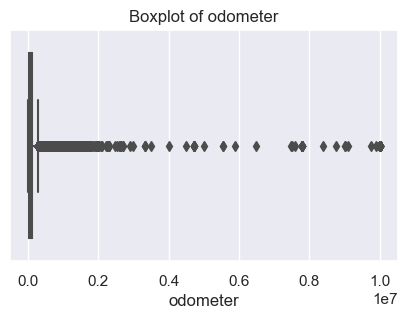

In [26]:
plt.figure(figsize = (5,3))
sns.boxplot(x = df2.odometer)
plt.title('Boxplot of odometer')
plt.show()

In reality, a car with having more than 1M miles is extremely rare, and the max value does not seem very probable

In [27]:
# Moreover, we can see that many values seem made up '9999999', '1234567', ...
df2[df2.odometer >= 1000000].odometer.value_counts()

9999999.00     45
1000000.00     45
10000000.00    20
1234567.00     20
1111111.00     19
               ..
1547940.00      1
2251212.00      1
1200290.00      1
7465644.00      1
1582919.00      1
Name: odometer, Length: 153, dtype: int64

In [28]:
filtered_data = df2[df2.odometer < 1000000]
dropped_data = df2[df2.odometer >= 1000000].index
print(f'{len(dropped_data)} rows will be dropped, this is {round(len(dropped_data)/len(df2)*100)}% of the dataset')

345 rows will be dropped, this is 0% of the dataset


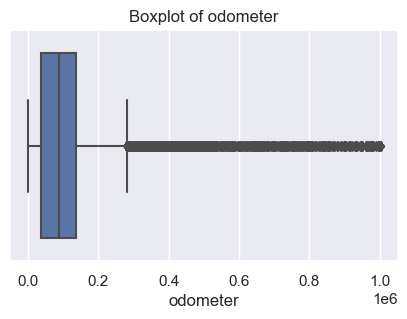

In [29]:
plt.figure(figsize = (5,3))
sns.boxplot(x = filtered_data.odometer)
plt.title('Boxplot of odometer')
plt.show()

In [30]:
df3 = df2.drop(dropped_data, axis = 0)
df3.reset_index(inplace = True, drop = True)
df3.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,austin,46995,2017.00,ford,f-150,NaN,8 cylinders,gas,48544.00,clean,automatic,4wd,truck,black,tx,29.68,-95.44
1,albany,36900,2016.00,ford,f-250 super duty,excellent,8 cylinders,gas,73394.00,clean,automatic,4wd,truck,white,ny,42.48,-73.38
2,"washington, DC",1399,2021.00,NaN,WOLF ISLANDER,NaN,NaN,gas,500.00,clean,automatic,NaN,other,orange,dc,38.76,-77.45
3,york,29590,2018.00,buick,enclave essence sport,good,6 cylinders,gas,38459.00,clean,other,fwd,SUV,white,pa,39.96,-76.73
4,lafayette / west lafayette,7950,2008.00,ford,f150 fx/2 sport,excellent,8 cylinders,gas,173267.00,clean,automatic,rwd,pickup,black,in,40.14,-87.62


## Cylinders

In [31]:
df3.cylinders.value_counts()

6 cylinders     68396
4 cylinders     55664
8 cylinders     50879
5 cylinders      1320
10 cylinders      890
other             777
3 cylinders       452
12 cylinders      119
Name: cylinders, dtype: int64

In [32]:
df4 = df3.copy()
df4.cylinders = [float(d) for d in df3.cylinders.str.extract(r'(\d+)')[0]]
df4.cylinders.value_counts()

6.00     68396
4.00     55664
8.00     50879
5.00      1320
10.00      890
3.00       452
12.00      119
Name: cylinders, dtype: int64

## Model

In [33]:
df4.model.value_counts()

f-150                          5449
silverado 1500                 3551
1500                           2903
camry                          2175
silverado                      2158
                               ... 
tundra 2wd truck limited          1
terrain slt-1 sport utility       1
spark ev 1lt hatchback 4d         1
dts limo                          1
4500 crew cab 4x4                 1
Name: model, Length: 23809, dtype: int64

"Model"  dropped as information not standardized. Same model cars are inputed with different names and many models only appeared once.

In [34]:
features_dropped.append('model')
df4.drop(['model'], axis = 1, inplace = True)

## Condition

In [35]:
df4.condition.value_counts()

good         94341
excellent    72982
like new     15260
fair          4756
new            714
salvage        332
Name: condition, dtype: int64

In [36]:
condition_dict = {'salvage':0,
                     'fair':1,
                     'good':2,
                     'excellent':3,
                     'like new':4,
                     'new':5}

df4['condition'] = df3['condition'].replace(condition_dict)
df4.head(3)

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,austin,46995,2017.00,ford,NaN,8.00,gas,48544.00,clean,automatic,4wd,truck,black,tx,29.68,-95.44
1,albany,36900,2016.00,ford,3.00,8.00,gas,73394.00,clean,automatic,4wd,truck,white,ny,42.48,-73.38
2,"washington, DC",1399,2021.00,NaN,NaN,NaN,gas,500.00,clean,automatic,NaN,other,orange,dc,38.76,-77.45


In [37]:
df4.condition.value_counts()

2.00    94341
3.00    72982
4.00    15260
1.00     4756
5.00      714
0.00      332
Name: condition, dtype: int64

## Fuel

In [38]:
df4.fuel.value_counts()

gas         253375
other        21618
diesel       19448
hybrid        3755
electric      1248
Name: fuel, dtype: int64

In [39]:
fuel_dict = {'gas':1,
                'other':0,
                'diesel':0,
                'hybrid':0,
                'electric':0}

df4['fuel'] = df3['fuel'].replace(fuel_dict)
df4.rename(columns = {'fuel':'fuel_gas'}, inplace = True)
df4.head(3)

,region,price,year,manufacturer,condition,cylinders,fuel_gas,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,austin,46995,2017.00,ford,NaN,8.00,1.00,48544.00,clean,automatic,4wd,truck,black,tx,29.68,-95.44
1,albany,36900,2016.00,ford,3.00,8.00,1.00,73394.00,clean,automatic,4wd,truck,white,ny,42.48,-73.38
2,"washington, DC",1399,2021.00,NaN,NaN,NaN,1.00,500.00,clean,automatic,NaN,other,orange,dc,38.76,-77.45


In [40]:
df4.fuel_gas.value_counts()

1.00    253375
0.00     46069
Name: fuel_gas, dtype: int64

## Title_status

In [41]:
df3.title_status.value_counts()

clean         286196
rebuilt         5638
salvage         2861
lien            1101
missing          478
parts only        87
Name: title_status, dtype: int64

In [42]:
title_status_dict = {'clean':1,
                'rebuilt':1,
                'salvage':0,
                'lien':0,
                'missing':0,
                'parts only':0}

df4['title_status'] = df3['title_status'].replace(title_status_dict)
df4.rename(columns = {'title_status':'title_status_ok'}, inplace = True)
df4.head(3)

,region,price,year,manufacturer,condition,cylinders,fuel_gas,odometer,title_status_ok,transmission,drive,type,paint_color,state,lat,long
0,austin,46995,2017.00,ford,NaN,8.00,1.00,48544.00,1.00,automatic,4wd,truck,black,tx,29.68,-95.44
1,albany,36900,2016.00,ford,3.00,8.00,1.00,73394.00,1.00,automatic,4wd,truck,white,ny,42.48,-73.38
2,"washington, DC",1399,2021.00,NaN,NaN,NaN,1.00,500.00,1.00,automatic,NaN,other,orange,dc,38.76,-77.45


## Transmission

In [43]:
df4.transmission.value_counts()

automatic    233593
other         48335
manual        18127
Name: transmission, dtype: int64

In [44]:
transmission_dict = {'automatic':1,
                'other':0,
                'manual':0}

df4['transmission'] = df3['transmission'].replace(transmission_dict)
df4.rename(columns = {'transmission':'transmission_automatic'}, inplace = True)
df4.head(3)

,region,price,year,manufacturer,condition,cylinders,fuel_gas,odometer,title_status_ok,transmission_automatic,drive,type,paint_color,state,lat,long
0,austin,46995,2017.00,ford,NaN,8.00,1.00,48544.00,1.00,1.00,4wd,truck,black,tx,29.68,-95.44
1,albany,36900,2016.00,ford,3.00,8.00,1.00,73394.00,1.00,1.00,4wd,truck,white,ny,42.48,-73.38
2,"washington, DC",1399,2021.00,NaN,NaN,NaN,1.00,500.00,1.00,1.00,NaN,other,orange,dc,38.76,-77.45


## Drive

In [45]:
df4.drive.value_counts()

4wd    91483
fwd    75841
rwd    42677
Name: drive, dtype: int64

## Type & Paint color

In [46]:
df4.type.value_counts()

sedan          61710
SUV            54210
pickup         32365
truck          22880
other          15537
coupe          13803
hatchback      12482
wagon           7787
van             6173
convertible     5694
mini-van        3630
offroad          456
bus              373
Name: type, dtype: int64

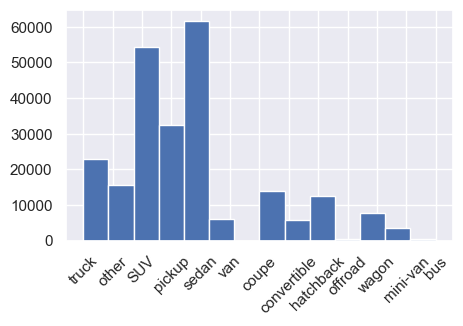

In [47]:
df4.type.hist(bins = len(set(df4.type)), figsize = (5,3))
plt.xticks(rotation=45)
plt.show()

In [48]:
top_4_type = df4.type.value_counts()[:4].index
   
df5 = df4.copy()
df5.type = ['other' if car_type not in top_4_type else car_type for car_type in df4.type] 
df5.type.value_counts()

other     130322
sedan      61710
SUV        54210
pickup     32365
truck      22880
Name: type, dtype: int64

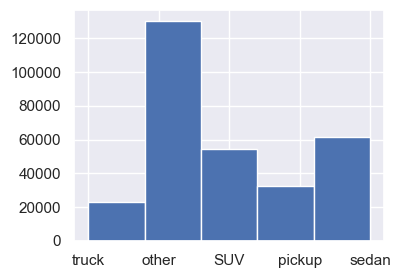

In [49]:
df5.type.hist(bins = 5, figsize = (4,3))
plt.show()

## paint_color

In [50]:
df5.paint_color.value_counts()

white     56704
black     45617
silver    31271
blue      22885
red       22522
grey      17645
green      5427
custom     4886
brown      4844
yellow     1574
orange     1432
purple      511
Name: paint_color, dtype: int64

In [51]:
d = {'silver':'grey'}

df6 = df5.copy()
df6.paint_color.replace(d, inplace = True)
    
top_4_colors = ['white', 'grey', 'black', 'blue']
    
df6.paint_color = ['other' if color not in top_4_colors else color for color in df6.paint_color]

In [52]:
df6.paint_color.value_counts()

other    127365
white     56704
grey      48916
black     45617
blue      22885
Name: paint_color, dtype: int64

## Location

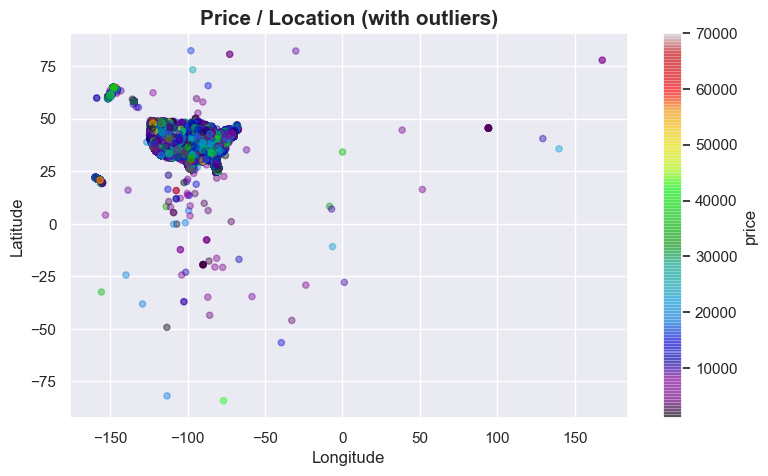

In [53]:
df6.plot(kind = 'scatter', x='long', y='lat', figsize = (9,5),
       alpha = 0.4, c = 'price', cmap = plt.get_cmap('nipy_spectral'), colorbar = True)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Price / Location (with outliers)', weight = 'bold', size = 15)
plt.show()

We can observe two things:
* After having removed the outliers, we can have a better view of the dispersion of car prices
* By only visualizing the lat/long values, we cannot easily identify any regions. Indeed, if we look closer, we can se that there are probably errors in the lat/long values as they show places outside the US that do not match with the "state" value.

In [54]:
df6[df6.lat < -0].head(1)[['region','state','lat','long']]

,region,state,lat,long
1756,hartford,ct,-7.65,-87.67


According to https://www.gps-coordinates.net/, 
* lat -7.646342 & long -87.667032 => Pacific Ocean (west) 
* state "ct" = Connecticut (on the north east side of the US)
* the region "hartford", however, does seem to be a city in Connecticut

In [55]:
df6.region.value_counts()

columbus                  2619
jacksonville              2430
omaha / council bluffs    2324
grand rapids              2311
milwaukee                 2305
                          ... 
meridian                    18
southwest MS                11
fort smith, AR               7
kansas city                  6
west virginia (old)          4
Name: region, Length: 404, dtype: int64

In [56]:
# Region seems to be cities, which is too detailed
# Lat & Long seem to not be very robust
to_drop = ['region','lat', 'long']
features_dropped.extend(to_drop)

df7 = df6.drop(to_drop, axis = 1)
df7.head()

,price,year,manufacturer,condition,cylinders,fuel_gas,odometer,title_status_ok,transmission_automatic,drive,type,paint_color,state
0,46995,2017.00,ford,NaN,8.00,1.00,48544.00,1.00,1.00,4wd,truck,black,tx
1,36900,2016.00,ford,3.00,8.00,1.00,73394.00,1.00,1.00,4wd,truck,white,ny
2,1399,2021.00,NaN,NaN,NaN,1.00,500.00,1.00,1.00,NaN,other,other,dc
3,29590,2018.00,buick,2.00,6.00,1.00,38459.00,1.00,0.00,fwd,SUV,white,pa
4,7950,2008.00,ford,3.00,8.00,1.00,173267.00,1.00,1.00,rwd,pickup,black,in


## State into US Regions
It is commonly accepted to regroup the states into 4 regions according to their greographical position:
* West
* Midwest
* South
* Northeast

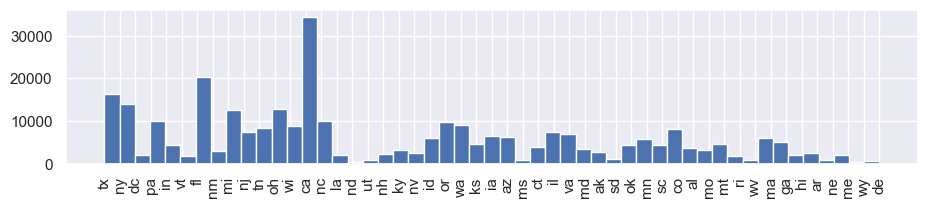

In [57]:
df7.state.hist(bins = 51, figsize = (11,2))
plt.xticks(rotation=90)
plt.show()

### Import states data
Using data from https://github.com/cphalpert/census-regions (org source: http://www.census.gov/geo/maps-data/maps/pdfs/reference/us_regdiv.pdf)

In [58]:
df_regions = pd.read_csv('states.csv')
df_regions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [59]:
df_regions['State Code'] = [code.lower() for code in df_regions['State Code']]
df_regions.head()

,State,State Code,Region,Division
0,Alaska,ak,West,Pacific
1,Alabama,al,South,East South Central
2,Arkansas,ar,South,West South Central
3,Arizona,az,West,Mountain
4,California,ca,West,Pacific


In [60]:
set(df_regions.Region)

{'Midwest', 'Northeast', 'South', 'West'}

In [61]:
region_values = df_regions['Region'].values
state_code = df_regions['State Code']

d_regions = dict(zip(state_code, region_values))

print(list(d_regions.keys())[0] + ' : ' + list(d_regions.values())[0])
print(list(d_regions.keys())[1] + ' : ' + list(d_regions.values())[1])

ak : West
al : South


#### Replacing State by Region

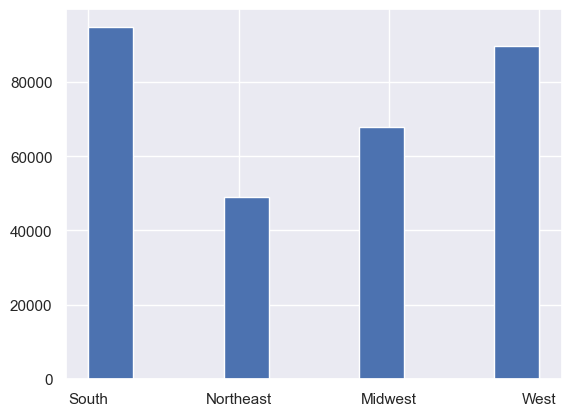

In [62]:
df8 = df7.copy()
df8['state'] = df8.state.replace(d_regions)
df8.rename(columns = {'state':'us_region'}, inplace = True)
df8['us_region'].hist()
plt.show()

## Manufacturer

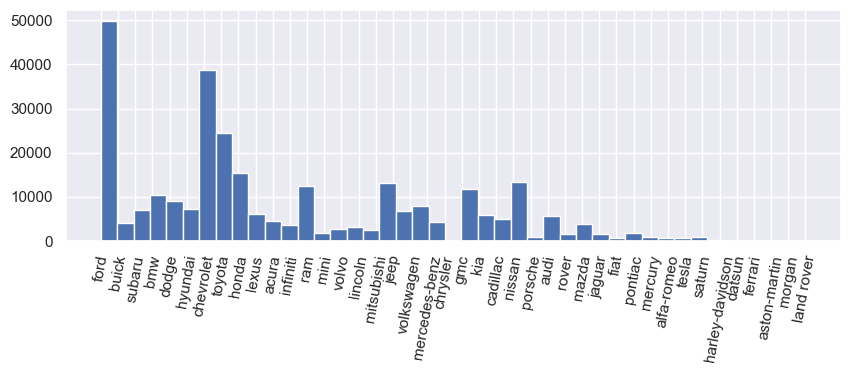

In [63]:
df8.manufacturer.hist(bins = len(set(df8.manufacturer)),figsize = (10,3))
plt.xticks(rotation=80)
plt.show()

To avoid having as much different values for a single feature, we can either:
* regroup by value => low freq. values to "other"
* regroup by shared characteristc => car country/continent of origin(ex: ford = America, chevrolet = America, ...)

The first is easier but more information is lost in the process. The second allows more information to be kept, but it needs domain knowleadge and/or an existing dataset that contains the missing information (car origin).

Since the range of values is relatively small (43), the needed dataset could be written by hand. However, if more models were added to the car dataset, the value could increase, and addding them by hand could take a lot of time.

The best option then is to scrap the needed data, preprocessed it, and then use it for our analysis. The website used to obtain this information is https://en.wikipedia.org/wiki/List_of_current_automobile_manufacturers_by_country.

In [64]:
df_car_origin = pd.read_csv('scraped_car_origin.csv')
df_car_origin

,africa,asia,europe,oceania,north america,south america
0,snvi,aftab automobiles,magna steyr,alpha sports,general motors,chamonix
1,egy-tech engineering,bmtf,ganja auto plant,bolwell,buick,fabral
2,kantanka cars,jamuna automobiles,khazar,borland racing developments,cadillac,tac
3,mobius motors,niloy-hero motors venture between hero motocor...,naz,devaux cars,chevrolet,troller
4,laraki,php automobiles,belgee,elfin sports cars,gmc,NaN
...,...,...,...,...,...,...
133,NaN,NaN,mclaren,NaN,NaN,NaN
134,NaN,NaN,mini,NaN,NaN,NaN
135,NaN,NaN,morgan,NaN,NaN,NaN
136,NaN,NaN,rolls-royce,NaN,NaN,NaN


In [65]:
# In our dataset, some compound brand names are separated by "-" while in Wikipedia they are separated by " ", thus:
df9 = df8.copy()

d_mod = {}
for brand in set(df9.manufacturer):
    if type(brand) == str:
        if ('-' in brand) and (brand != 'mercedes-benz'):
            d_mod[brand] = re.sub('-',' ',brand)
df9.manufacturer = df9.manufacturer.replace(d_mod)            

In [66]:
dict_cars_origin = {}

for brand in set(df9.manufacturer):
    if len(df_car_origin[df_car_origin.isin([f'{brand}'])].stack()) > 0:
        dict_cars_origin[f'{brand}'] = df_car_origin[df_car_origin.isin([f'{brand}'])].stack().index[0][1]

In [67]:
dict_cars_origin

{'dodge': 'north america ',
 'mini': 'europe ',
 'tesla': 'north america ',
 'gmc': 'north america ',
 'hyundai': 'asia ',
 'infiniti': 'asia ',
 'mazda': 'asia ',
 'alfa romeo': 'europe ',
 'volvo': 'europe ',
 'volkswagen': 'europe ',
 'ram': 'north america ',
 'bmw': 'europe ',
 'cadillac': 'north america ',
 'chevrolet': 'north america ',
 'jaguar': 'europe ',
 'lincoln': 'north america ',
 'datsun': 'asia ',
 'ferrari': 'europe ',
 'aston martin': 'europe ',
 'morgan': 'europe ',
 'chrysler': 'north america ',
 'mercedes-benz': 'europe ',
 'buick': 'north america ',
 'nissan': 'asia ',
 'acura': 'asia ',
 'land rover': 'europe ',
 'porsche': 'europe ',
 'mitsubishi': 'asia ',
 'lexus': 'asia ',
 'ford': 'north america ',
 'subaru': 'asia ',
 'toyota': 'asia ',
 'kia': 'asia ',
 'fiat': 'europe ',
 'honda': 'asia ',
 'audi': 'europe ',
 'jeep': 'north america '}

In [68]:
s1 = set(df9.manufacturer)
s2 = set(dict_cars_origin.keys())

print(f'From a total of {df9.manufacturer.nunique()} brands, {len(s1.difference(s2))} are missing:\n\t {s1.difference(s2)}')

From a total of 42 brands, 6 are missing:
	 {nan, 'rover', 'mercury', 'saturn', 'harley davidson', 'pontiac'}


To avoid losing data, and since is a small % of the data, the remaining brands will be added manually:

In [69]:
dict_cars_origin['saturn'] = 'north america '
dict_cars_origin['rover'] = 'europe '
dict_cars_origin['pontiac'] = 'north america '
dict_cars_origin['mercury'] = 'north america '
dict_cars_origin['harley davidson'] = 'north america '

In [70]:
df9.manufacturer = df9.manufacturer.replace(dict_cars_origin)

In [71]:
df9.manufacturer.value_counts()

north america     156022
asia               93549
europe             40265
Name: manufacturer, dtype: int64

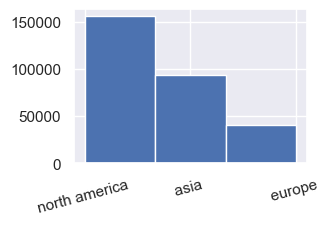

In [72]:
df9.manufacturer.hist(bins = df9.manufacturer.nunique(),figsize = (3,2))
plt.xticks(rotation=15)
plt.show()

## Dealing with missing data

In [73]:
df9.isna().sum() / df9.shape[0] * 100

price                     0.00
year                      0.29
manufacturer              3.86
condition                37.51
cylinders                41.05
fuel_gas                  0.68
odometer                  0.54
title_status_ok           1.70
transmission_automatic    0.47
drive                    30.34
type                      0.00
paint_color               0.00
us_region                 0.00
dtype: float64

In [74]:
# It is safest to drop the rows containing too much missing values, else the majority of obs for those cars would be artificial
rows_to_drop = df9[df9.isnull().sum(axis = 1) > 4]
rows_to_drop

,price,year,manufacturer,condition,cylinders,fuel_gas,odometer,title_status_ok,transmission_automatic,drive,type,paint_color,us_region
548,57995,NaN,NaN,NaN,8.00,NaN,9363.00,NaN,1.00,4wd,SUV,grey,Midwest
639,5595,2011.00,north america,NaN,NaN,NaN,0.00,NaN,1.00,NaN,other,other,Northeast
846,25399,NaN,NaN,NaN,4.00,NaN,8492.00,1.00,1.00,NaN,SUV,white,Midwest
1180,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,South
2378,15995,NaN,NaN,NaN,4.00,1.00,24865.00,NaN,1.00,NaN,SUV,grey,Midwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298097,6800,2016.00,asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,Northeast
298577,9999,2017.00,asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,South
300444,12600,2018.00,north america,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,other,Northeast
301238,10000,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,NaN,other,other,South


In [75]:
to_drop = rows_to_drop.index
df10 = df9.drop(to_drop, axis = 0)
print('Rows dropped: ', len(rows_to_drop))

Rows dropped:  488


### How to handle missing data
* Size has 72% of missing data => safest option is to drop the feature 
    * imputing would be done without enough data 
    * removing the rows with missing "size" data would mean to lose more than 70% of our dataset
* As for the remaining features, although containing sometimes high % of missing data (condition, cylinders about 40%), a good option is to impute values. To do so, is better to first encode categorical features so they can be included in the process.

The chosen imputer model is https://scikit-learn.org/stable/modules/impute.html#iterative-imputer. 
* The IterativeImputer "models each feature with missing values as a function of other features, and uses that estimate for imputation".

The reason of this choice is because missing data is probably MAR (Missing at Random), and thus, looking at other features can help us estimate the missing data:
* MCAR - Missing Completetly at Random
    * Missing data is completely random (ex: error at inputing value), and other features cannot help us predict the missing value. In this case best approaches could be imputing with "mean" or "median" if outliers are present in the dataset.
* MAR - Missing at Random
    * Missing values cannot be explained by the feature itself, but by other features. Ex: the number of cylinders of one car cannot really help us predict the same feature for another car, but similar vehicules (aka other features values are similar) can help us predict it.
* MNAR - Missing NOT at Random
    * Missing data is not random. Ex: very high or very low income households will avoid giving their income more often than those with an average income; same goes for weight. In this case, before imputing, an analysis on the missing data must be conducted.

## One Hot Encoding (dummy variables)

In [76]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300999 entries, 0 to 301486
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   300999 non-null  int64  
 1   year                    300264 non-null  float64
 2   manufacturer            289608 non-null  object 
 3   condition               188385 non-null  float64
 4   cylinders               177608 non-null  float64
 5   fuel_gas                299354 non-null  float64
 6   odometer                299610 non-null  float64
 7   title_status_ok         296306 non-null  float64
 8   transmission_automatic  299848 non-null  float64
 9   drive                   209963 non-null  object 
 10  type                    300999 non-null  object 
 11  paint_color             300999 non-null  object 
 12  us_region               300999 non-null  object 
dtypes: float64(7), int64(1), object(5)
memory usage: 32.2+ MB


In [77]:
categorical_features = df10.select_dtypes(include = ['object']).columns

In [78]:
df11 = pd.get_dummies(df10)
df11.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel_gas', 'odometer',
       'title_status_ok', 'transmission_automatic', 'manufacturer_asia ',
       'manufacturer_europe ', 'manufacturer_north america ', 'drive_4wd',
       'drive_fwd', 'drive_rwd', 'type_SUV', 'type_other', 'type_pickup',
       'type_sedan', 'type_truck', 'paint_color_black', 'paint_color_blue',
       'paint_color_grey', 'paint_color_other', 'paint_color_white',
       'us_region_Midwest', 'us_region_Northeast', 'us_region_South',
       'us_region_West'],
      dtype='object')

In [79]:
dummies_to_drop = ['manufacturer_europe ', 'drive_4wd', 'type_other', 'paint_color_other', 'us_region_Northeast']
df11.drop(dummies_to_drop, axis = 1, inplace = True)

In [80]:
df11.shape

(300999, 23)

In [81]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

imp = IterativeImputer(random_state = 42, skip_complete = True,
                      min_value = [df11.iloc[:, i].min() for i in range(len(df11.columns))],
                      max_value = [df11.iloc[:, i].max() for i in range(len(df11.columns))])

In [82]:
temp = imp.fit_transform(df11)
df12 = pd.DataFrame(temp, columns = df11.columns)

In [83]:
df12.describe()

,price,year,condition,cylinders,fuel_gas,odometer,title_status_ok,transmission_automatic,manufacturer_asia,manufacturer_north america,drive_fwd,drive_rwd,type_SUV,type_pickup,type_sedan,type_truck,paint_color_black,paint_color_blue,paint_color_grey,paint_color_white,us_region_Midwest,us_region_South,us_region_West
count,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00,300999.00
mean,18970.88,2010.99,2.60,5.91,0.85,94575.95,0.98,0.78,0.31,0.52,0.25,0.14,0.18,0.11,0.20,0.08,0.15,0.08,0.16,0.19,0.23,0.31,0.30
std,13488.51,9.50,0.58,1.38,0.36,70675.10,0.12,0.41,0.46,0.50,0.43,0.35,0.38,0.31,0.40,0.27,0.36,0.26,0.37,0.39,0.42,0.46,0.46
min,1000.00,1900.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7975.00,2008.00,2.00,4.83,1.00,39169.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,15988.00,2013.00,2.73,6.00,1.00,88432.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,27950.00,2017.00,3.00,6.71,1.00,136119.50,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
max,70000.00,2022.00,5.00,12.00,1.00,999999.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Correlation analysis

In [84]:
continuous_features = ['price','odometer']

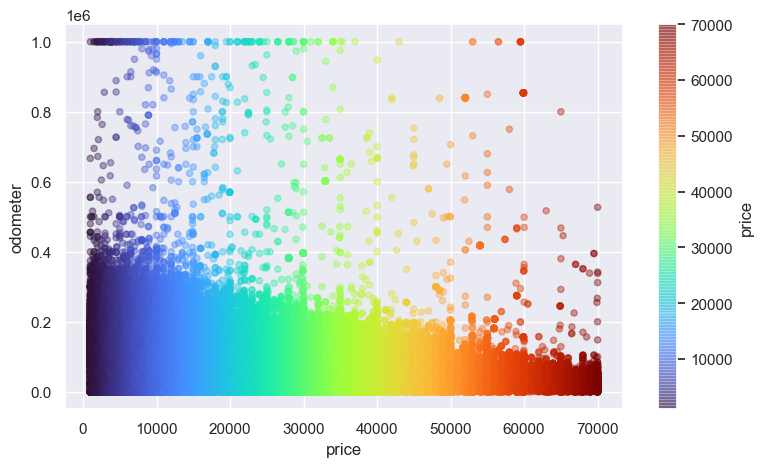

In [85]:
df12.plot(kind = 'scatter', x='price', y='odometer', figsize = (9,5),
       alpha = 0.4, c = 'price', cmap = plt.get_cmap('turbo'), colorbar = True)
plt.show()

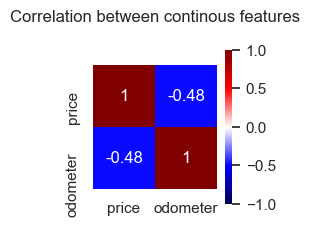

In [86]:
corr = df12[continuous_features].corr(method = 'pearson')

f, ax = plt.subplots(figsize=(2, 2))
ax = sns.heatmap(corr, annot = True, vmin = -1, vmax=1, square=True, cmap = 'seismic')
for t in ax.texts:
    if abs(float(t.get_text()))>=0.2:
         t.set_text(t.get_text()) 
    else:
         t.set_text("")
plt.title('Correlation between continous features\n\n')
plt.show()

In [87]:
df_discrete_features = df12.loc[:, (df12.columns != 'price') & (df12.columns !=  'odometer')]

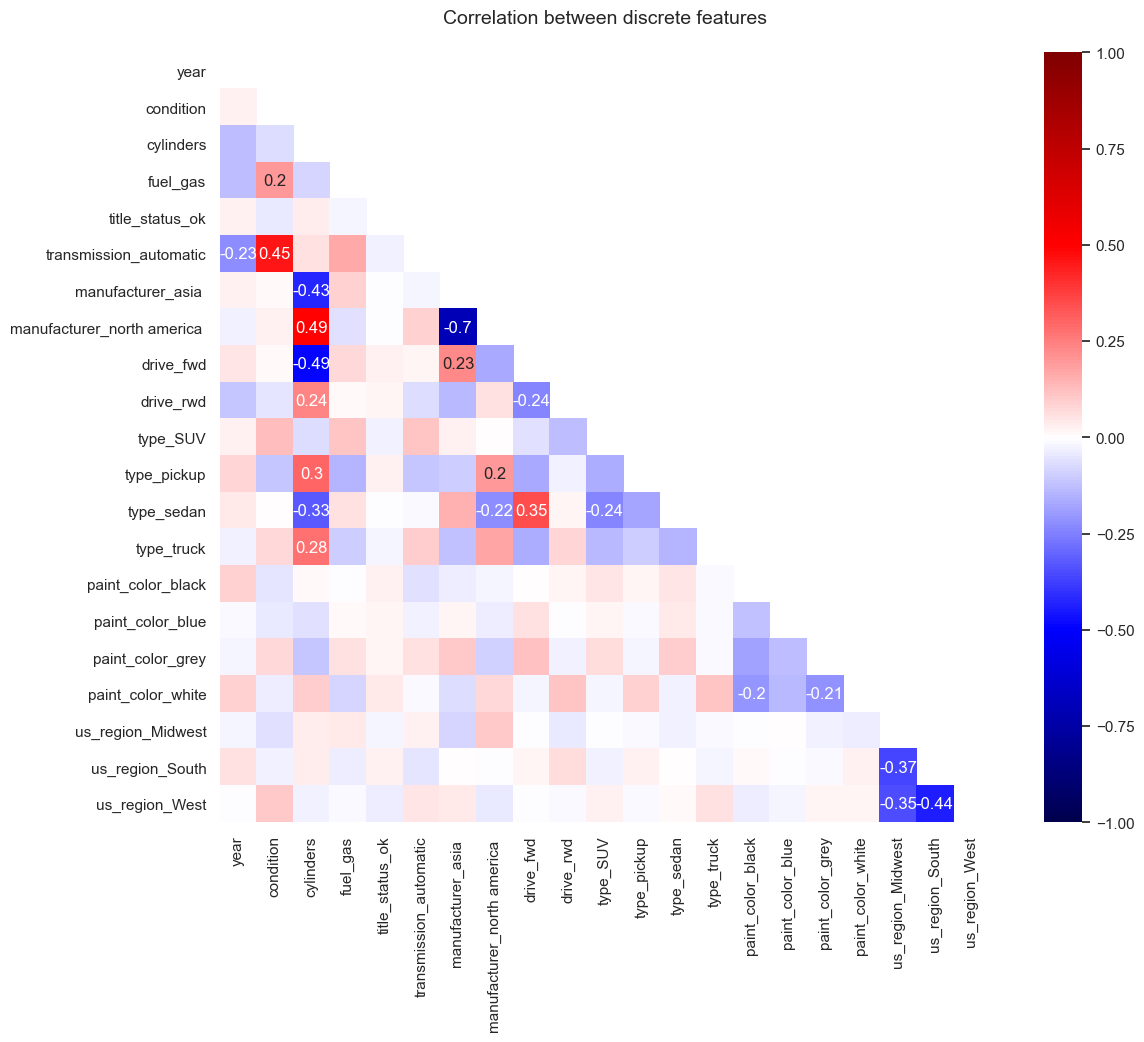

In [88]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://stackoverflow.com/questions/66099438/how-to-annot-only-values-greater-than-x-on-a-seaborn-heatmap

corr = df_discrete_features.corr(method = 'spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr, mask=mask, annot = True, vmin = -1, vmax=1, square=True, cmap = 'seismic')
    for t in ax.texts:
        if abs(float(t.get_text()))>=0.2:
            t.set_text(t.get_text()) 
        else:
            t.set_text("")
plt.title('Correlation between discrete features\n', size = 14)
plt.show()

# Check of modifications

In [89]:
# Features dropped
print(f'{len(features_dropped)} features were dropped:\n {features_dropped[:6]}\n {features_dropped[6:]}')

13 features were dropped:
 ['url', 'region_url', 'VIN', 'image_url', 'id', 'description']
 ['posting_date', 'county', 'size', 'model', 'region', 'lat', 'long']


In [90]:
# Features added (with one hot encoding)
with_dummy_variables = set(df11.columns)
regular_variables = set(df10.columns)

dummy_created = with_dummy_variables.difference(regular_variables)
net_new_features = len(dummy_created)-len(categorical_features)


print('Features created:\n')
print(f' There were {len(categorical_features)} categorical features, that were replaced by {len(dummy_created)} new features:')
print(f' {dummy_created}')
print(f'\n => In total, after one-hot encoding, there are {net_new_features} more columns than before')

Features created:

 There were 5 categorical features, that were replaced by 15 new features:
 {'manufacturer_north america ', 'drive_rwd', 'manufacturer_asia ', 'us_region_South', 'paint_color_blue', 'paint_color_white', 'type_truck', 'us_region_West', 'paint_color_black', 'type_pickup', 'drive_fwd', 'us_region_Midwest', 'type_sedan', 'paint_color_grey', 'type_SUV'}

 => In total, after one-hot encoding, there are 10 more columns than before


In [91]:
# Net difference on features
print('Summary features:\n')
print(f' {len(features_dropped)} features were dropped, {len(categorical_features)} were replaced and {len(dummy_created)} were created')
print(f'=> In net terms, the final dataframe contains {len(features_dropped)+len(categorical_features)-len(dummy_created)} less features')

Summary features:

 13 features were dropped, 5 were replaced and 15 were created
=> In net terms, the final dataframe contains 3 less features


In [92]:
# Before & After
print(f'Before preprocessing, the data shape was {train_set.shape}')
print(f' After preprocessing, the data shape was {df12.shape}')

Before preprocessing, the data shape was (341504, 26)
 After preprocessing, the data shape was (300999, 23)


In [93]:
# Rows removed
print(f'{len(train_set) - len(df12)} rows were droppped, this is {round((len(train_set) - len(df12)) / len(train_set) * 100, 2)}% of the data')

40505 rows were droppped, this is 11.86% of the data
